In [ ]:
# Imports

# Gymnasium
# -----------------------
import gymnasium as gym
from gymnasium import spaces
import gymnasium as gym
from gymnasium.wrappers import RecordEpisodeStatistics
import numpy as np

# -----------------------
# Stable Baselines 3
# -----------------------
import optuna

from stable_baselines3 import DQN, A2C
from stable_baselines3.common.evaluation import evaluate_policy
from qlearning import tabular_q_learning


# -----------------------
# Importing the water environment
# -----------------------
from env_nosell import create_env, SimplifiedWaterSupplyEnv

In [2]:
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor


def make_tabular_env(time_buckets=10, water_buckets=5, max_cycles=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = create_env(max_cycles=max_cycles,
                     time_buckets=time_buckets,
                     water_buckets=water_buckets,
                     discrete_actions=True,
                     discrete_observations=True)
    return Monitor(env, filename='tabular q')

def make_dqn_env(time_buckets=10, water_buckets=5, max_cycles=5):
    """
    Creates a tabular Q-learning friendly environment from the continuous
    Pendulum-v1 environment by discretizing both observations and actions.
    """
    env = create_env(max_cycles=max_cycles,
                     time_buckets=time_buckets,
                     water_buckets=water_buckets,
                     discrete_actions=True,
                     discrete_observations=False,
                     normalize_actions=False,
                     normalize_observations=True)
    
    return Monitor(env, filename='dqn')



def make_a2c_env(max_cycles=5):
    env = create_env(max_cycles=max_cycles,
                    discrete_actions=False,
                    discrete_observations=False,
                    normalize_actions=True,
                    normalize_observations=True)
    return Monitor(env, filename='a2c')


In [3]:
env = make_tabular_env(time_buckets=10, water_buckets=10)
Q, rewards = tabular_q_learning(env, total_episodes=100)

c:\Users\AcerC\OneDrive\מסמכים\SDMRL-Project\iftah-eram-sdmrl\eran_temp_work\version_2\qlearning.py:54: RuntimeWarning: invalid value encountered in scalar subtract
  Q[state, action] += learning_rate * (reward + gamma * np.max(Q[new_state, :]) - Q[state, action])


Episode 100: Total Reward = -21855.5125


In [4]:
from env_nosell import HOURS_IN_A_WEEK

# 1. Tabular q-learning objective
def tabular_q_learning_objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.9, 1)
    epsilon = trial.suggest_float("epsilon", 0.01, 1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.01, 1)
    time_buckets = trial.suggest_categorical('time_buckets', [5, 10, 20])
    water_buckets = trial.suggest_categorical('water_buckets', [5, 10, 20])
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])

    total_timesteps = 50000  # Use a smaller budget for tuning

    env = make_tabular_env(time_buckets, water_buckets)
    # Run Q-learning for num_episodes episodes
    Q, total_rewards = tabular_q_learning(env,
                                          total_episodes=total_timesteps // (HOURS_IN_A_WEEK * max_cycles),
                                          learning_rate=learning_rate,
                                          gamma=gamma,
                                          epsilon=epsilon,
                                          epsilon_decay=epsilon_decay)
    
    # Return the average reward (since we want to maximize reward)
    return np.mean(total_rewards)

# 2. DQN objective using Stable-Baselines3.
def objective_dqn(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    buffer_size = trial.suggest_categorical('buffer_size', [50000, 100000, 200000])
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    exploration_fraction = trial.suggest_float('exploration_fraction', 0.1, 0.5)
    exploration_final_eps = trial.suggest_float('exploration_final_eps', 0.01, 0.1)
    target_update_interval = trial.suggest_categorical('target_update_interval', [100, 500, 1000])
    time_buckets = trial.suggest_categorical('time_buckets', [5, 10, 20])
    water_buckets = trial.suggest_categorical('water_buckets', [5, 10, 20])
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])
    
    env = make_dqn_env(time_buckets,
                       water_buckets,
                       max_cycles)
    model = DQN("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma,
                buffer_size=buffer_size, batch_size=batch_size,
                exploration_fraction=exploration_fraction, exploration_final_eps=exploration_final_eps,
                target_update_interval=target_update_interval, verbose=0, device='cpu')
    # Train for a limited number of timesteps.
    model.learn(total_timesteps=5000, progress_bar=True)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

# 3. A2C objective using Stable-Baselines3.
def objective_a2c(trial):
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float('gamma', 0.90, 0.999)
    n_steps = trial.suggest_categorical('n_steps', [5, 10, 20, 50])
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)
    vf_coef = trial.suggest_float('vf_coef', 0.1, 1.0)
    max_grad_norm = trial.suggest_float('max_grad_norm', 0.5, 1.0)
    max_cycles = trial.suggest_categorical('max_cycles', [1, 3, 5])
    
    env=make_a2c_env(max_cycles)
    model = A2C("MlpPolicy", env, learning_rate=learning_rate, gamma=gamma, n_steps=n_steps,
                ent_coef=ent_coef, vf_coef=vf_coef, max_grad_norm=max_grad_norm, verbose=0, device='cpu')
    model.learn(total_timesteps=5000, progress_bar=True)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
    return mean_reward

study_tabular = optuna.create_study(direction="maximize")
study_tabular.optimize(tabular_q_learning_objective, n_trials=3)
print("Best hyperparameters for Tabular Q-learning:", study_tabular.best_trial.params)

# Tune DQN.
study_dqn = optuna.create_study(direction="maximize")
study_dqn.optimize(objective_dqn, n_trials=3)
print("Best hyperparameters for DQN:", study_dqn.best_trial.params)

# Tune A2C.
study_a2c = optuna.create_study(direction="maximize")
study_a2c.optimize(objective_a2c, n_trials=3)
print("Best hyperparameters for A2C:", study_a2c.best_trial.params)


[I 2025-03-02 00:26:05,534] A new study created in memory with name: no-name-e5d3745d-d9ae-40e9-b9cd-0f99a07fb302
[I 2025-03-02 00:26:06,811] Trial 0 finished with value: -7582095.15871212 and parameters: {'lr': 0.00014516973297845574, 'gamma': 0.9568491755797094, 'epsilon': 0.04747182397827734, 'epsilon_decay': 0.23581014810906056, 'time_buckets': 5, 'water_buckets': 5, 'max_cycles': 3}. Best is trial 0 with value: -7582095.15871212.
[I 2025-03-02 00:26:08,012] Trial 1 finished with value: -10066428.279924242 and parameters: {'lr': 4.041369719930558e-05, 'gamma': 0.9222283338669713, 'epsilon': 0.21673290740307483, 'epsilon_decay': 0.625606260202253, 'time_buckets': 5, 'water_buckets': 5, 'max_cycles': 3}. Best is trial 0 with value: -7582095.15871212.


Episode 100: Total Reward = -42000320.8375
Episode 200: Total Reward = -3540.1375


[I 2025-03-02 00:26:11,557] Trial 2 finished with value: -17598185.709217172 and parameters: {'lr': 3.202450195679797e-05, 'gamma': 0.925424105991313, 'epsilon': 0.10882231103376551, 'epsilon_decay': 0.249052321616551, 'time_buckets': 5, 'water_buckets': 10, 'max_cycles': 1}. Best is trial 0 with value: -7582095.15871212.
[I 2025-03-02 00:26:11,558] A new study created in memory with name: no-name-1d19c8b2-ad4b-48d5-af38-7de0f75b4001


Best hyperparameters for Tabular Q-learning: {'lr': 0.00014516973297845574, 'gamma': 0.9568491755797094, 'epsilon': 0.04747182397827734, 'epsilon_decay': 0.23581014810906056, 'time_buckets': 5, 'water_buckets': 5, 'max_cycles': 3}


Output()

[I 2025-03-02 00:26:17,320] Trial 0 finished with value: -9749452.2794288 and parameters: {'lr': 0.0002615233257215767, 'gamma': 0.9723735778388287, 'buffer_size': 200000, 'batch_size': 128, 'exploration_fraction': 0.354740525950787, 'exploration_final_eps': 0.09146874085020398, 'target_update_interval': 1000, 'time_buckets': 10, 'water_buckets': 5, 'max_cycles': 1}. Best is trial 0 with value: -9749452.2794288.


Output()

[I 2025-03-02 00:26:22,161] Trial 1 finished with value: -26809397.593049 and parameters: {'lr': 2.6159226078206782e-05, 'gamma': 0.9756168557847411, 'buffer_size': 200000, 'batch_size': 128, 'exploration_fraction': 0.3584895924406907, 'exploration_final_eps': 0.060558517166134786, 'target_update_interval': 500, 'time_buckets': 10, 'water_buckets': 10, 'max_cycles': 3}. Best is trial 0 with value: -9749452.2794288.


Output()

[I 2025-03-02 00:26:26,003] Trial 2 finished with value: -209150136.16209918 and parameters: {'lr': 8.838109836557229e-05, 'gamma': 0.969510345669155, 'buffer_size': 100000, 'batch_size': 32, 'exploration_fraction': 0.480100529390591, 'exploration_final_eps': 0.060601196761927344, 'target_update_interval': 1000, 'time_buckets': 20, 'water_buckets': 5, 'max_cycles': 3}. Best is trial 0 with value: -9749452.2794288.
[I 2025-03-02 00:26:26,003] A new study created in memory with name: no-name-b08210f3-c303-4d45-b309-4474b04503ff


Output()

C:\Users\AcerC\AppData\Local\Temp\ipykernel_25388\3887417489.py:58: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  ent_coef = trial.suggest_loguniform('ent_coef', 1e-8, 1e-2)


Best hyperparameters for DQN: {'lr': 0.0002615233257215767, 'gamma': 0.9723735778388287, 'buffer_size': 200000, 'batch_size': 128, 'exploration_fraction': 0.354740525950787, 'exploration_final_eps': 0.09146874085020398, 'target_update_interval': 1000, 'time_buckets': 10, 'water_buckets': 5, 'max_cycles': 1}


[I 2025-03-02 00:26:30,325] Trial 0 finished with value: -3235572462.395008 and parameters: {'lr': 0.00027949190105832717, 'gamma': 0.9173706752015163, 'n_steps': 20, 'ent_coef': 0.0011338452234402557, 'vf_coef': 0.8283710183608742, 'max_grad_norm': 0.8587331197293777, 'max_cycles': 5}. Best is trial 0 with value: -3235572462.395008.


Output()

[I 2025-03-02 00:26:34,351] Trial 1 finished with value: -621849725.7679336 and parameters: {'lr': 0.00012136458039770784, 'gamma': 0.9242585494987215, 'n_steps': 10, 'ent_coef': 1.1694413961394799e-05, 'vf_coef': 0.3008234339702645, 'max_grad_norm': 0.9708340274605822, 'max_cycles': 1}. Best is trial 1 with value: -621849725.7679336.


Output()

[I 2025-03-02 00:26:39,629] Trial 2 finished with value: -617958870.4333943 and parameters: {'lr': 0.0008119390262748507, 'gamma': 0.9472543146883086, 'n_steps': 5, 'ent_coef': 9.275420147352106e-08, 'vf_coef': 0.4320913106599342, 'max_grad_norm': 0.6777768322823153, 'max_cycles': 1}. Best is trial 2 with value: -617958870.4333943.


Best hyperparameters for A2C: {'lr': 0.0008119390262748507, 'gamma': 0.9472543146883086, 'n_steps': 5, 'ent_coef': 9.275420147352106e-08, 'vf_coef': 0.4320913106599342, 'max_grad_norm': 0.6777768322823153, 'max_cycles': 1}


In [7]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

# Import RL algorithms from Stable-Baselines3
from stable_baselines3 import DQN, A2C
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

# ========================================================
# STEP 3: BASELINE PERFORMANCE COMPARISON SETUP
# ========================================================
# We assume the water supply environment ("YourWaterSupplyEnv-v0")
# is registered with Gymnasium and uses discrete observation/action spaces.
# We also assume that the tabular Q-learning implementation (q_learning function)
# and the optimal hyperparameters for each algorithm have already been obtained.

# --- (1) Define the experiment runners for each agent type ---
# Each function runs the corresponding algorithm for a fixed training duration,
# evaluates performance on evaluation episodes, and returns the evaluation score.

# (a) Tabular Q-Learning Experiment Runner
def run_tabular_q_learning(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the tabular Q-learning experiment with given seed and hyperparameters.
    
    optimal_params: dict with keys 'alpha', 'gamma', 'epsilon', and 'num_episodes'
    Returns: Average reward over evaluation episodes.
    """
    np.random.seed(seed)
    env = make_tabular_env(time_buckets=optimal_params['time_buckets'],
                           water_buckets=optimal_params['water_buckets'],
                           max_cycles=optimal_params['max_cycles'])
    # Set the environment seed (if supported by your environment)
    env.reset(seed=seed)
    
    # Run our previously defined Q-learning algorithm.
    Q, rewards_all = tabular_q_learning(env,
                                total_episodes=total_timesteps // (HOURS_IN_A_WEEK * optimal_params['max_cycles']),
                                learning_rate=optimal_params['lr'],
                                gamma=optimal_params['gamma'],
                                epsilon=optimal_params['epsilon'],
                                epsilon_decay=optimal_params['epsilon_decay'])
    
    # Evaluate the learned Q-table:
    # Here we use a simple evaluation function: run a few episodes with a greedy policy.
    eval_rewards = []
    env = make_tabular_env(time_buckets=optimal_params['time_buckets'],
                           water_buckets=optimal_params['water_buckets'],
                           max_cycles=optimal_params['max_cycles'])
    for _ in range(n_eval_episodes):
        state, info = env.reset()
        done = False
        truncated = False
        total_reward = 0
        while not done and not truncated:
            # Greedy action selection based on Q-table.
            action = int(np.argmax(Q[state]))
            next_state, reward, done, truncated, info = env.step(action)
            total_reward += reward
            state = next_state
        eval_rewards.append(total_reward)
    training_times = env.get_episode_times()
    return eval_rewards, [rewards_all], training_times, Q, env

# (b) DQN Experiment Runner using Stable-Baselines3
def run_dqn(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the DQN experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'learning_rate', 'gamma', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_dqn_env(time_buckets=optimal_params['time_buckets'],
                       water_buckets=optimal_params['water_buckets'],
                       max_cycles=optimal_params['max_cycles'])
    
    env.reset(seed=seed)
    model = DQN("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                buffer_size=optimal_params['buffer_size'],
                batch_size=optimal_params['batch_size'],
                exploration_fraction=optimal_params['exploration_fraction'],
                exploration_final_eps=optimal_params['exploration_final_eps'],
                target_update_interval=optimal_params['target_update_interval'],
                seed=seed,
                verbose=0,
                device='cpu')
    # Train model for a fixed number of timesteps.
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# (c) A2C Experiment Runner using Stable-Baselines3
def run_a2c(seed, optimal_params, total_timesteps=5000, n_eval_episodes=5):
    """
    Runs the A2C experiment with the given seed and hyperparameters.
    
    optimal_params: dict with keys such as 'lr', 'gamma', 'n_steps', etc.
    Returns: Mean reward over evaluation episodes.
    """
    env = make_a2c_env()
    env.reset(seed=seed)
    model = A2C("MlpPolicy", env,
                learning_rate=optimal_params['lr'],
                gamma=optimal_params['gamma'],
                n_steps=optimal_params['n_steps'],
                ent_coef=optimal_params['ent_coef'],
                vf_coef=optimal_params['vf_coef'],
                max_grad_norm=optimal_params['max_grad_norm'],
                seed=seed,
                verbose=0,
                device='cpu')
    model.learn(total_timesteps=total_timesteps, progress_bar=True)
    eval_rewards, _ = evaluate_policy(model, env, n_eval_episodes=n_eval_episodes, return_episode_rewards=True)
    training_rewards = env.get_episode_rewards()
    training_times = env.get_episode_times()
    return eval_rewards, [training_rewards], training_times, model, env

# ========================================================
# (2) Run Experiments Across Multiple Seeds for Each Agent
# ========================================================
# Define a list of seeds for reproducibility.
seeds = range(4)

# Assume these optimal hyperparameters have been determined from Step 2.
optimal_params_tabular = study_tabular.best_trial.params

optimal_params_dqn = study_dqn.best_trial.params

optimal_params_a2c = study_a2c.best_trial.params

# Containers for results: a dictionary mapping algorithm name to list of evaluation rewards.
results = {
    "Tabular_Q": [],
    "DQN": [],
    "A2C": []
}

learning_curves = {"Tabular_Q": [],
                   "DQN": [],
                   "A2C": []}
training_times = {"Tabular_Q": [],
                  "DQN": [],
                  "A2C": []}



# Run experiments for each seed.
for seed in seeds:
    print(f"Running experiment with seed: {seed}")
    
    # Run Tabular Q-learning.
    reward_tabular, tabular_learning_curve, tabular_training_times, Q, tabular_env = run_tabular_q_learning(seed,
                                                                                                            optimal_params_tabular,
                                                                                                            total_timesteps=5000,
                                                                                                            n_eval_episodes=10)
    results["Tabular_Q"].append(reward_tabular)
    learning_curves['Tabular_Q'].append(np.array(tabular_learning_curve))
    training_times['Tabular_Q'].append(tabular_training_times)
    print(f"Tabular Q-learning (seed {seed}): {reward_tabular}")
    
    # Run DQN.
    reward_dqn, dqn_learning_curve, dqn_training_times, dqn_model, dqn_env = run_dqn(seed,
                                                                                     optimal_params_dqn,
                                                                                     total_timesteps=5000,
                                                                                     n_eval_episodes=10)
    results["DQN"].append(reward_dqn)
    learning_curves['DQN'].append(np.array(dqn_learning_curve))
    training_times['DQN'].append(dqn_training_times)
    print(f"DQN (seed {seed}): {reward_dqn}")
    
    # Run A2C.
    reward_a2c, a2c_learning_curve, a2c_training_times, a2c_model, a2c_env = run_a2c(seed,
                                                                                     optimal_params_a2c,
                                                                                     total_timesteps=5000,
                                                                                     n_eval_episodes=10)
    results["A2C"].append(reward_a2c)
    learning_curves['A2C'].append(np.array(a2c_learning_curve))
    training_times['A2C'].append(a2c_training_times)
    print(f"A2C (seed {seed}): {reward_a2c}")


learning_curves = {a: np.array(s) for a, s in learning_curves.items()}
results = {a: np.array(s) for a, s in results.items()}
training_times = {a: np.array(s) for a, s in training_times.items()}

a2c_model.save("a2c_model")
dqn_model.save("dqn_model")



Output()

Running experiment with seed: 0
Tabular Q-learning (seed 0): [-54000000.2625, -48000000.2625, -48000000.2625, -54000000.2625, -54000000.2625, -48000000.2625, -48000000.2625, -42000000.2625, -54000000.2625, -48000000.2625]


Output()

DQN (seed 0): [-8934400.768093, -9999301.709553, -8991950.460715, -9698949.991032, -9674604.75319, -9939857.293005, -9397358.22333, -8692803.46974, -9405056.405965, -8586187.859323]


Output()

A2C (seed 0): [-3199645138.603611, -3210862805.346422, -3200156836.962004, -3258923126.464202, -3222498024.368577, -3215656819.723189, -3225226413.144368, -3224081030.798324, -3209435913.858527, -3231096942.314191]
Running experiment with seed: 1
Tabular Q-learning (seed 1): [-24000788.662499998, -42000788.662499994, -30000788.6625, -30000788.6625, -42000788.662499994, -36000788.6625, -30000788.662499998, -30000788.6625, -24000788.662499998, -36000788.6625]


Output()

Output()

A2C (seed 1): [-3241036909.122296, -3213880242.826264, -3215654405.333233, -3217579120.022437, -3223287733.908955, -3229611161.746177, -3242507249.048833, -3192855175.384987, -3217528845.053416, -3221891538.665026]
Running experiment with seed: 2
Tabular Q-learning (seed 2): [-42000572.66250001, -36000572.6625, -36000572.662499994, -36000572.6625, -42000572.66250001, -42000572.66250001, -36000572.662499994, -42000572.6625, -36000572.662499994, -42000572.662499994]


Output()

DQN (seed 2): [-7658237.070259, -10197437.854836, -9612989.226793, -9425849.38931, -9632981.99281, -9459404.180755, -8412525.41981, -9009024.640988, -9520854.550365, -9287700.683473]


Output()

A2C (seed 2): [-3151436201.104053, -3294190066.029053, -3205422035.253881, -3228898490.757537, -3325206729.142418, -3225334667.498196, -3235880048.467717, -3225493171.565633, -3197556201.746094, -3205913842.933247]
Running experiment with seed: 3
Tabular Q-learning (seed 3): [-54000000.2625, -48000000.2625, -42000000.2625, -60000000.2625, -54000000.2625, -48000000.2625, -54000000.2625, -48000000.2625, -54000000.2625, -42000000.2625]


Output()

DQN (seed 3): [-9822385.602477, -11136888.207322, -9074224.598761, -9957050.802175, -9753836.398577, -8469626.083314, -10573173.789318, -11006628.490265, -9171338.334312, -10787352.991156]


A2C (seed 3): [-3236878091.935746, -3195830116.193033, -3213534602.197114, -3224460506.380522, -3212102421.122776, -3224953319.303233, -3220929751.492986, -3198831429.948583, -3219409491.07564, -3276290312.014999]


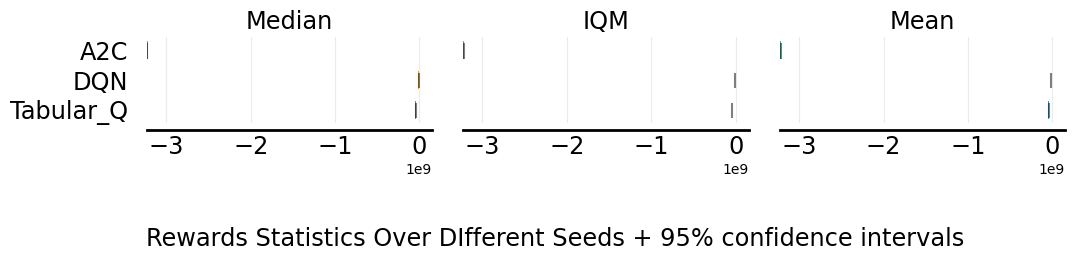

In [9]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(learning_curves.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  results, aggregate_func, reps=1000)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(results.keys()),
  xlabel='Rewards Statistics Over DIfferent Seeds + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

In [21]:
learning_curves['DQN']

array([[[-4.94386250e+03, -9.05686250e+03, -7.58986250e+03, ...,
         -8.69280347e+06, -9.40505641e+06, -8.58618786e+06]],

       [[-6.85366250e+03, -4.05016250e+03, -7.76536250e+03, ...,
         -9.06045686e+06, -9.13716909e+06, -1.01469373e+07]],

       [[-5.00596250e+03, -7.34236250e+03, -6.64756250e+03, ...,
         -9.00902464e+06, -9.52085455e+06, -9.28770068e+06]],

       [[-6.21286250e+03, -4.74316250e+03, -7.70866250e+03, ...,
         -1.10066285e+07, -9.17133833e+06, -1.07873530e+07]]])

In [26]:
learning_curves['Tabular_Q'].shape

(4, 1, 9)

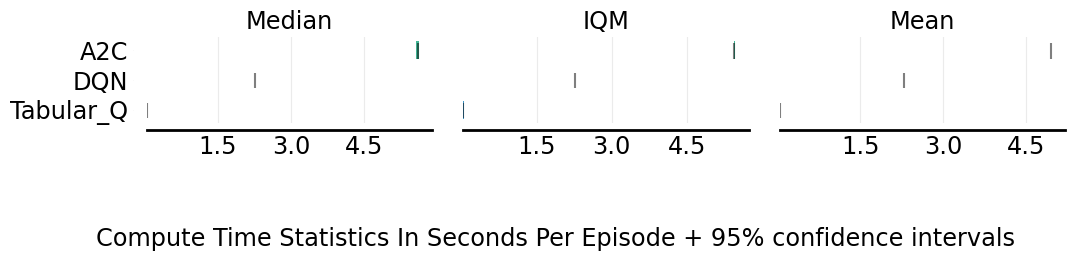

In [11]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd


algorithms = list(training_times.keys())

aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x)])

aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
  training_times, aggregate_func, reps=10)


fig, axes = plot_utils.plot_interval_estimates(
  aggregate_scores, aggregate_score_cis,
  metric_names=['Median', 'IQM', 'Mean'],
  algorithms=list(training_times.keys()),
  xlabel='Compute Time Statistics In Seconds Per Episode + 95% confidence intervals',
  xlabel_y_coordinate=-1
  )

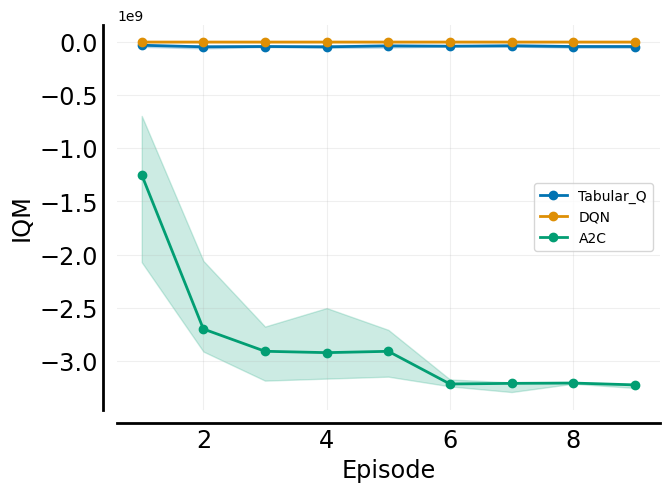

In [17]:
## IQM learning curves (the IQM for per episode number across different seeds)
frame_scale = min([s.shape[-1] for s in learning_curves.values()])
frames = np.arange(0, frame_scale, frame_scale // 10 + 1)
frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in learning_curves.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  frames_scores_dict, iqm, reps=50)


ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=algorithms,
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')


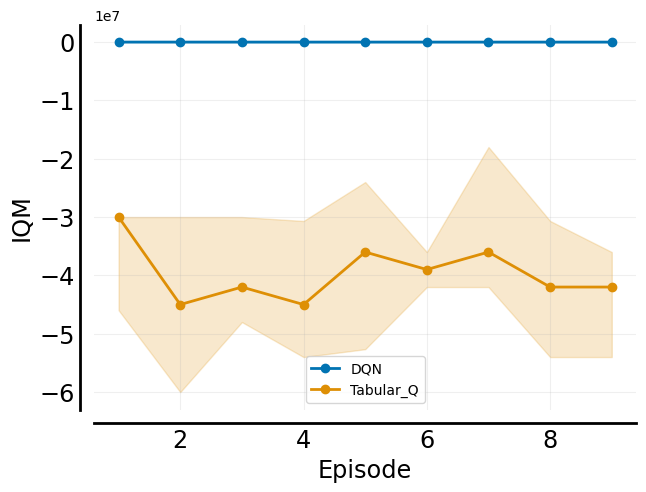

In [19]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=["DQN", "Tabular_Q"],
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')


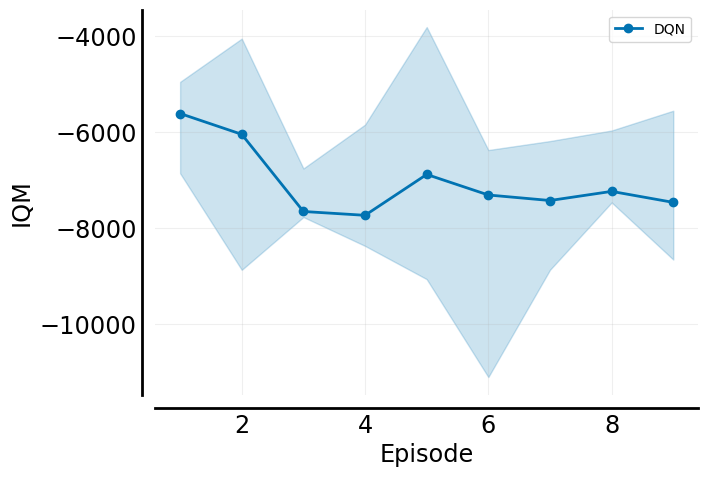

In [25]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=["DQN"],
    xlabel=r'Episode',
    ylabel='IQM')

ax.legend(loc='best')

In [22]:
import optuna
from mcts_finetuned_model import MCTSFinetunedTabularQ
from env_nosell import create_env
import numpy as np
from qlearning import TabularQ

def high_level_model_objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.9, 1)
    epsilon = trial.suggest_float("epsilon", 0.01, 1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.01, 1)


    n_episodes = 100 # Use a smaller budget for tuning

    env = create_env(discrete_actions=True,
                     discrete_observations=True,
                     water_buckets=50,
                     max_cycles=5,
                     time_buckets=50)

    # Run Q-learning for num_episodes episodes
    model = MCTSFinetunedTabularQ(mcts_iters=10,
                              mcts_horizon=3,
                              high_level_action_granularity=10,
                              simulator=env)
    total_rewards = model.train(env,
                                total_episodes=n_episodes,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                epsilon=epsilon,
                                epsilon_decay=epsilon_decay)
    
    # Return the average reward (since we want to maximize reward)
    return np.mean(total_rewards)

def tabular_q_learning_objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    gamma = trial.suggest_float("gamma", 0.9, 1)
    epsilon = trial.suggest_float("epsilon", 0.01, 1)
    epsilon_decay = trial.suggest_float("epsilon_decay", 0.01, 1)


    n_episodes = 100 # Use a smaller budget for tuning

    env = create_env(discrete_actions=True,
                     discrete_observations=True,
                     water_buckets=50,
                     max_cycles=5,
                     time_buckets=50)

    # Run Q-learning for num_episodes episodes
    model = TabularQ(env)
    total_rewards = model.train(env,
                                total_episodes=n_episodes,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                epsilon=epsilon,
                                epsilon_decay=epsilon_decay)
    
    # Return the average reward (since we want to maximize reward)
    return np.mean(total_rewards)

study_high_level_model = optuna.create_study(direction="maximize")
study_high_level_model.optimize(high_level_model_objective, n_trials=30)
study_baseline_tabular_model = optuna.create_study(direction="maximize")
study_baseline_tabular_model.optimize(tabular_q_learning_objective, n_trials=30)

print("Best hyperparameters for Tabular Q-learning:", study_high_level_model.best_trial.params)


[I 2025-03-03 13:44:49,233] A new study created in memory with name: no-name-4e186343-f44f-4547-baa8-4ce643d87c86
Low Level Policy: 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]
[I 2025-03-03 13:44:58,235] Trial 0 finished with value: -965658.7837999999 and parameters: {'lr': 0.0008193896240884736, 'gamma': 0.9788823693327365, 'epsilon': 0.6134192796920549, 'epsilon_decay': 0.44961267955386597}. Best is trial 0 with value: -965658.7837999999.
Low Level Policy: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]
[I 2025-03-03 13:45:07,102] Trial 1 finished with value: -997547.7710000004 and parameters: {'lr': 9.416131836775518e-05, 'gamma': 0.9338142925572617, 'epsilon': 0.5407471254334921, 'epsilon_decay': 0.40020869405925463}. Best is trial 0 with value: -965658.7837999999.
Low Level Policy: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]
[I 2025-03-03 13:45:16,133] Trial 2 finished with value: -4536606.051799997 and parameters: {'lr': 0.0008131798433518436, 'gamma': 0.9936320884823817,

Episode 100: Total Reward = -28846999.909999885


[I 2025-03-03 13:49:22,046] Trial 1 finished with value: -42537590.44639997 and parameters: {'lr': 2.822593557838499e-05, 'gamma': 0.9968370206890756, 'epsilon': 0.5290285046216329, 'epsilon_decay': 0.32397989256331605}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -28899781.3699999


[I 2025-03-03 13:49:24,185] Trial 2 finished with value: -40236031.11979995 and parameters: {'lr': 1.1668721166508881e-05, 'gamma': 0.9952951127447514, 'epsilon': 0.2994299359801679, 'epsilon_decay': 0.4751837548980651}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -28771509.10999988


[I 2025-03-03 13:49:26,326] Trial 3 finished with value: -48987547.331 and parameters: {'lr': 0.0007008118539253828, 'gamma': 0.9889738639197179, 'epsilon': 0.0652469867821275, 'epsilon_decay': 0.8138053231481444}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -47009955.34999999


[I 2025-03-03 13:49:28,465] Trial 4 finished with value: -55616011.82780006 and parameters: {'lr': 1.2146599904678105e-05, 'gamma': 0.9394479645186808, 'epsilon': 0.10302720545912719, 'epsilon_decay': 0.0761797684029879}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -48320231.02999998


[I 2025-03-03 13:49:30,662] Trial 5 finished with value: -50793953.64620001 and parameters: {'lr': 1.3997762516655105e-05, 'gamma': 0.9391018460745116, 'epsilon': 0.9868104854703185, 'epsilon_decay': 0.15685641774411788}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -46659202.85


[I 2025-03-03 13:49:32,801] Trial 6 finished with value: -46806894.93979999 and parameters: {'lr': 6.699433293583246e-05, 'gamma': 0.979138177073683, 'epsilon': 0.19261024265648122, 'epsilon_decay': 0.15659919301756015}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -35126350.30999992


[I 2025-03-03 13:49:34,957] Trial 7 finished with value: -47087652.85279999 and parameters: {'lr': 9.531622181643098e-05, 'gamma': 0.9616743794149354, 'epsilon': 0.039775792837501336, 'epsilon_decay': 0.9471104068544868}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -32132024.989999913


[I 2025-03-03 13:49:37,143] Trial 8 finished with value: -36827217.261799954 and parameters: {'lr': 2.2878728636664222e-05, 'gamma': 0.9095535760515258, 'epsilon': 0.6926281696284935, 'epsilon_decay': 0.6393628691833423}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -32383909.129999887


[I 2025-03-03 13:49:39,422] Trial 9 finished with value: -49535053.76480003 and parameters: {'lr': 0.0006507163185229212, 'gamma': 0.9803776763382679, 'epsilon': 0.5423334882263461, 'epsilon_decay': 0.11124225379995525}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -33523188.04999988


[I 2025-03-03 13:49:41,622] Trial 10 finished with value: -37859357.67979995 and parameters: {'lr': 0.0002929353979417789, 'gamma': 0.9088843938514262, 'epsilon': 0.7953656027806735, 'epsilon_decay': 0.5923918602747708}. Best is trial 0 with value: -33416879.667199925.


Episode 100: Total Reward = -33696145.0099999


[I 2025-03-03 13:49:43,798] Trial 11 finished with value: -31217170.882399928 and parameters: {'lr': 0.00022284355752029994, 'gamma': 0.9028610797712231, 'epsilon': 0.7166433768070422, 'epsilon_decay': 0.6451315803814401}. Best is trial 11 with value: -31217170.882399928.


Episode 100: Total Reward = -30407005.309999887


[I 2025-03-03 13:49:45,915] Trial 12 finished with value: -34304329.92319994 and parameters: {'lr': 0.000254735314622813, 'gamma': 0.9260906632341012, 'epsilon': 0.7249908021664406, 'epsilon_decay': 0.4148169646137973}. Best is trial 11 with value: -31217170.882399928.


Episode 100: Total Reward = -34065404.749999896


[I 2025-03-03 13:49:48,045] Trial 13 finished with value: -25139942.87839994 and parameters: {'lr': 0.00026019147918252244, 'gamma': 0.9599896594807749, 'epsilon': 0.8833149580016157, 'epsilon_decay': 0.7249081966499997}. Best is trial 13 with value: -25139942.87839994.


Episode 100: Total Reward = -21310397.20999994


[I 2025-03-03 13:49:50,151] Trial 14 finished with value: -26194146.89179995 and parameters: {'lr': 0.0002312433296720407, 'gamma': 0.963811279230521, 'epsilon': 0.957017184969272, 'epsilon_decay': 0.7674149900883298}. Best is trial 13 with value: -25139942.87839994.


Episode 100: Total Reward = -18989565.40999996


[I 2025-03-03 13:49:52,338] Trial 15 finished with value: -26754398.83819995 and parameters: {'lr': 0.00015716930849641396, 'gamma': 0.962090095111489, 'epsilon': 0.9707002654454212, 'epsilon_decay': 0.8070994359741531}. Best is trial 13 with value: -25139942.87839994.


Episode 100: Total Reward = -27489210.109999932


[I 2025-03-03 13:49:54,474] Trial 16 finished with value: -25300613.69839995 and parameters: {'lr': 6.300525802230683e-05, 'gamma': 0.966590224589489, 'epsilon': 0.8562715879584679, 'epsilon_decay': 0.7810938243790677}. Best is trial 13 with value: -25139942.87839994.


Episode 100: Total Reward = -22800143.86999995


[I 2025-03-03 13:49:56,686] Trial 17 finished with value: -16858216.76359997 and parameters: {'lr': 5.985091017568498e-05, 'gamma': 0.9726559115489329, 'epsilon': 0.383625459423616, 'epsilon_decay': 0.9236702909497451}. Best is trial 17 with value: -16858216.76359997.


Episode 100: Total Reward = -18956965.429999944


[I 2025-03-03 13:49:58,867] Trial 18 finished with value: -11870564.169799993 and parameters: {'lr': 4.36083163714271e-05, 'gamma': 0.9757399811168568, 'epsilon': 0.3711438895950566, 'epsilon_decay': 0.9666258647045006}. Best is trial 18 with value: -11870564.169799993.


Episode 100: Total Reward = -17401613.20999998


[I 2025-03-03 13:50:01,006] Trial 19 finished with value: -11796302.569999993 and parameters: {'lr': 3.353624518213214e-05, 'gamma': 0.974480466508188, 'epsilon': 0.38110437153205035, 'epsilon_decay': 0.9602090773659491}. Best is trial 19 with value: -11796302.569999993.


Episode 100: Total Reward = -17633672.329999983


[I 2025-03-03 13:50:03,159] Trial 20 finished with value: -7983474.537200005 and parameters: {'lr': 3.251802288324087e-05, 'gamma': 0.9854629018043674, 'epsilon': 0.394649036592049, 'epsilon_decay': 0.9741620419828633}. Best is trial 20 with value: -7983474.537200005.


Episode 100: Total Reward = -12675093.23


[I 2025-03-03 13:50:05,342] Trial 21 finished with value: -1756005.2708 and parameters: {'lr': 3.327046668303866e-05, 'gamma': 0.982547757602126, 'epsilon': 0.3285060503373531, 'epsilon_decay': 0.9998430901487457}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -1045015.4899999981


[I 2025-03-03 13:50:07,538] Trial 22 finished with value: -21834587.319799945 and parameters: {'lr': 2.9389986921656743e-05, 'gamma': 0.986599341187399, 'epsilon': 0.397303704659628, 'epsilon_decay': 0.8820721248163907}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -26192720.149999917


[I 2025-03-03 13:50:09,828] Trial 23 finished with value: -5470264.793000008 and parameters: {'lr': 2.1464558835408812e-05, 'gamma': 0.9850680380254345, 'epsilon': 0.2687404698925449, 'epsilon_decay': 0.9949982302914148}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -1176244.4899999958


[I 2025-03-03 13:50:12,069] Trial 24 finished with value: -28661304.430999923 and parameters: {'lr': 1.7324744944836525e-05, 'gamma': 0.999946116514235, 'epsilon': 0.24610366767298247, 'epsilon_decay': 0.8664428401324187}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -30933619.78999988


[I 2025-03-03 13:50:14,236] Trial 25 finished with value: -11529384.786199998 and parameters: {'lr': 1.9521890997504416e-05, 'gamma': 0.985001137667271, 'epsilon': 0.15774210099713853, 'epsilon_decay': 0.9928224535455707}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -10743035.030000003


[I 2025-03-03 13:50:16,458] Trial 26 finished with value: -28176397.725799907 and parameters: {'lr': 4.079078517872277e-05, 'gamma': 0.9904987345972596, 'epsilon': 0.28301376198836514, 'epsilon_decay': 0.878563840944065}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -27764048.449999902


[I 2025-03-03 13:50:18,666] Trial 27 finished with value: -34117587.03199992 and parameters: {'lr': 0.00012480172753702586, 'gamma': 0.9524843837609823, 'epsilon': 0.4628121698084829, 'epsilon_decay': 0.7263206044360621}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -27280706.209999923


[I 2025-03-03 13:50:20,797] Trial 28 finished with value: -44212110.73459999 and parameters: {'lr': 1.0030628119575706e-05, 'gamma': 0.9699745894141348, 'epsilon': 0.4472272530304987, 'epsilon_decay': 0.305586609105538}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -26192283.829999913


[I 2025-03-03 13:50:23,009] Trial 29 finished with value: -23255532.558799934 and parameters: {'lr': 4.40789872446929e-05, 'gamma': 0.9821757888793018, 'epsilon': 0.5994419948748734, 'epsilon_decay': 0.8698631683080156}. Best is trial 21 with value: -1756005.2708.


Episode 100: Total Reward = -25264398.889999915
Best hyperparameters for Tabular Q-learning: {'lr': 2.6628201958041416e-05, 'gamma': 0.9150030578789041, 'epsilon': 0.7978821521944404, 'epsilon_decay': 0.9750774943208798}


In [23]:
study_high_level_model.best_params

{'lr': 2.6628201958041416e-05,
 'gamma': 0.9150030578789041,
 'epsilon': 0.7978821521944404,
 'epsilon_decay': 0.9750774943208798}

In [37]:
from mcts_finetuned_model import MCTSFinetunedTabularQ, DiscretizedActionWrapper
from qlearning import TabularQ
from env_nosell import create_env
import numpy as np
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils
import pandas as pd

high_level_optimal_params = study_high_level_model.best_params
base_line_optimal_params = study_baseline_tabular_model.best_params
seeds = range(10)
env = create_env(discrete_actions=True, discrete_observations=True, water_buckets=50, max_cycles=5, time_buckets=50, normalize_rewards=False)
discretized_env = DiscretizedActionWrapper(env, granularity=10)
learning_curves = {'high_level': [],
                   'tabular': []
                   }
for seed in seeds:
    env.reset(seed=seed)
    high_level_model = MCTSFinetunedTabularQ(high_level_action_granularity=10,
                                        simulator=env,
                                        mcts_iters=10,
                                        mcts_horizon=3)
    learning_curves['high_level'].append([high_level_model.train(env,
                                                                 total_episodes=300,
                                                                 learning_rate=high_level_optimal_params['lr'],
                                                                 gamma=high_level_optimal_params['gamma'],
                                                                 epsilon=high_level_optimal_params['epsilon'],
                                                                 epsilon_decay=high_level_optimal_params['epsilon_decay'],
                                                                 min_epsilon=0,
                                                                 high_level_policy_episodes_percentage=0.7)])
    initial_state = env.reset(seed=seed)
    tabular_q_learning_model = TabularQ(env)
    learning_curves['tabular'].append([tabular_q_learning_model.train(env,
                                                                      total_episodes=300,                                                                  learning_rate=high_level_optimal_params['lr'],
                                                                 gamma=base_line_optimal_params['gamma'],
                                                                 epsilon=base_line_optimal_params['epsilon'],
                                                                 epsilon_decay=base_line_optimal_params['epsilon_decay'],
                                                                 min_epsilon=0)])
    

training high level policy:  54%|█████▍    | 114/210 [00:02<00:02, 42.69it/s]

Episode 100: Total Reward = -143303.14999999994


training high level policy: 100%|██████████| 210/210 [00:04<00:00, 42.88it/s]


Episode 200: Total Reward = -146444.14999999988


Low Level Policy: 100%|██████████| 90/90 [00:56<00:00,  1.59it/s]


Episode 100: Total Reward = -772468.9699999986
Episode 200: Total Reward = -3893455.9099999988
Episode 300: Total Reward = -1321203.469999998


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 44.32it/s]

Episode 100: Total Reward = -152699.15000000002


training high level policy: 100%|██████████| 210/210 [00:04<00:00, 44.34it/s]

Episode 200: Total Reward = -140834.44999999992


Low Level Policy: 100%|██████████| 90/90 [00:56<00:00,  1.59it/s]


Episode 100: Total Reward = -2706128.0900000045
Episode 200: Total Reward = -1397865.529999996
Episode 300: Total Reward = -1166948.1499999957


training high level policy:  52%|█████▏    | 110/210 [00:02<00:02, 44.83it/s]

Episode 100: Total Reward = -155883.3500000001


training high level policy: 100%|██████████| 210/210 [00:04<00:00, 43.34it/s]

Episode 200: Total Reward = -147669.9500000001


Low Level Policy: 100%|██████████| 90/90 [00:56<00:00,  1.58it/s]


Episode 100: Total Reward = -924749.6299999997
Episode 200: Total Reward = -166133.15000000026
Episode 300: Total Reward = -126630.28999999975


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 47.03it/s]

Episode 100: Total Reward = -164575.54999999996


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 44.61it/s]

Episode 200: Total Reward = -165480.9499999999


Low Level Policy: 100%|██████████| 90/90 [00:55<00:00,  1.61it/s]


Episode 100: Total Reward = -835746.949999999
Episode 200: Total Reward = -1438889.7499999946
Episode 300: Total Reward = -1377566.0299999954


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 43.68it/s]

Episode 100: Total Reward = -157404.34999999995


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 45.59it/s]

Episode 200: Total Reward = -158765.15000000002


Low Level Policy: 100%|██████████| 90/90 [00:55<00:00,  1.63it/s]


Episode 100: Total Reward = -1735817.5099999986
Episode 200: Total Reward = -207328.66999999995
Episode 300: Total Reward = -151067.2699999998


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 42.36it/s]

Episode 100: Total Reward = -164410.84999999983


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 44.62it/s]

Episode 200: Total Reward = -169500.34999999998


Low Level Policy: 100%|██████████| 90/90 [00:55<00:00,  1.61it/s]


Episode 100: Total Reward = -1308974.9899999953
Episode 200: Total Reward = -120694.96999999974
Episode 300: Total Reward = -115119.46999999978


training high level policy:  52%|█████▏    | 110/210 [00:02<00:02, 43.23it/s]

Episode 100: Total Reward = -148177.54999999993


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 44.96it/s]

Episode 200: Total Reward = -154266.9499999999


Low Level Policy: 100%|██████████| 90/90 [00:55<00:00,  1.62it/s]


Episode 100: Total Reward = -308936.6299999999
Episode 200: Total Reward = -843807.5299999997
Episode 300: Total Reward = -1134057.4699999974


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 45.48it/s]

Episode 100: Total Reward = -155760.9499999999


training high level policy: 100%|██████████| 210/210 [00:04<00:00, 44.59it/s]

Episode 200: Total Reward = -154877.14999999994


Low Level Policy: 100%|██████████| 90/90 [00:55<00:00,  1.61it/s]


Episode 100: Total Reward = -2572334.1500000074
Episode 200: Total Reward = -250109.5100000006
Episode 300: Total Reward = -119306.2699999998


training high level policy:  52%|█████▏    | 110/210 [00:02<00:02, 41.66it/s]

Episode 100: Total Reward = -169767.6499999999


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 42.88it/s]

Episode 200: Total Reward = -177825.34999999995


Low Level Policy: 100%|██████████| 90/90 [00:56<00:00,  1.60it/s]


Episode 100: Total Reward = -249644.5700000003
Episode 200: Total Reward = -1249845.11
Episode 300: Total Reward = -120483.28999999973


training high level policy:  50%|█████     | 105/210 [00:02<00:02, 41.88it/s]

Episode 100: Total Reward = -148364.74999999994


training high level policy:  98%|█████████▊| 205/210 [00:04<00:00, 45.13it/s]

Episode 200: Total Reward = -160962.0499999999


Low Level Policy: 100%|██████████| 90/90 [00:56<00:00,  1.61it/s]


Episode 100: Total Reward = -4071583.550000002
Episode 200: Total Reward = -117044.20999999977
Episode 300: Total Reward = -423961.9700000008


In [49]:
results = {a: np.array(v) for a, v in learning_curves.items()}

In [50]:
frame_scale = min([s.shape[-1] for s in results.values()])
frames = np.arange(0, frame_scale, 10)
frames_scores_dict = {algorithm: score[:, :, frames] for algorithm, score
                          in results.items()}
iqm = lambda scores: np.array([metrics.aggregate_iqm(scores[..., frame])
                               for frame in range(scores.shape[-1])])
iqm_scores, iqm_cis = rly.get_interval_estimates(
  frames_scores_dict, iqm, reps=50)


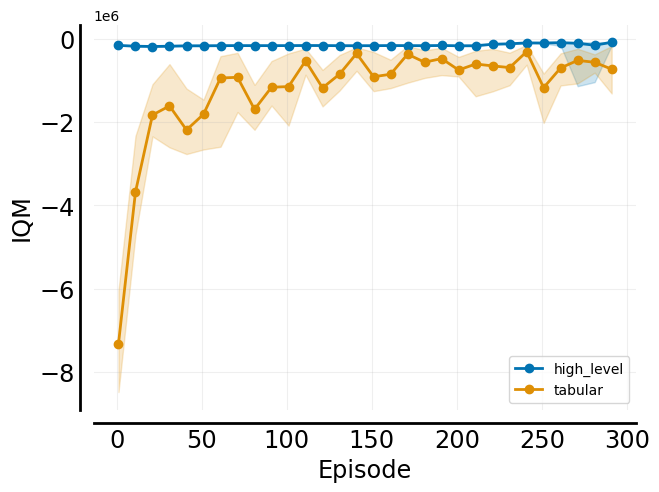

In [51]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, iqm_scores, iqm_cis, algorithms=['high_level', 'tabular'],
    xlabel=r'Episode',
    ylabel='IQM')


ax.legend(loc='best')


In [52]:
loss_iqm = {a: np.log(s * -1) for a, s in iqm_scores.items()}
loss_cis = {a: np.log(s * -1) for a, s in iqm_cis.items()}

matplotlib.axes._axes.Axes

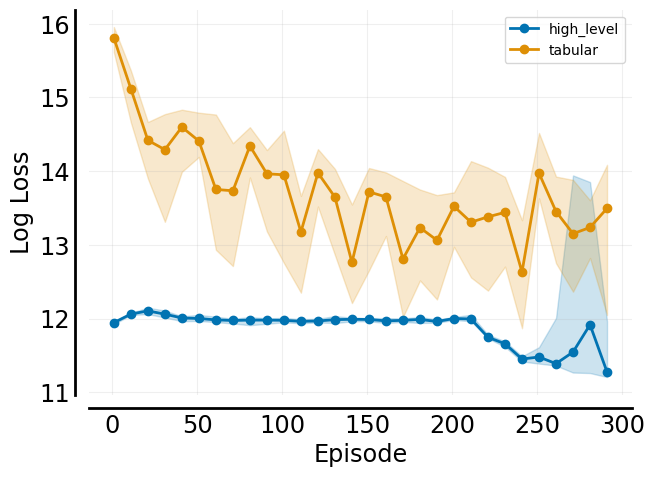

In [53]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, loss_iqm, loss_cis, algorithms=['high_level', 'tabular'],
    xlabel=r'Episode',
    ylabel='Log Loss')

ax.legend(loc='best')
type(ax)

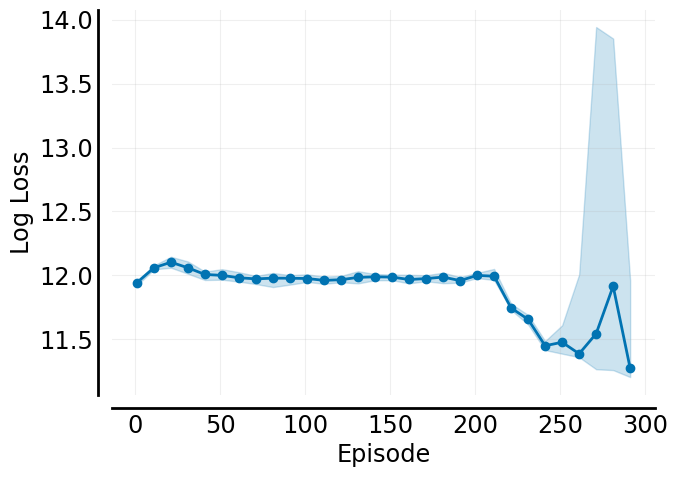

In [55]:
ax = plot_utils.plot_sample_efficiency_curve(
    frames+1, loss_iqm, loss_cis, algorithms=['high_level'],
    xlabel=r'Episode',
    ylabel='Log Loss')

In [43]:
import numpy as np
def record_and_analyze_trajectories(model, env, num_episodes=5):
    trajectories = []
    for ep in range(num_episodes):
        obs, info = env.reset()
        state = env.unwrapped.get_state()
        done = False
        timestep = 0
        while not done:
            action = model.predict(state)
            next_obs, reward, done, _, next_info = env.step(action)
            if type(action) in [np.int64, int]:
                action = env.env.action(action)
            buy_from_a, buy_from_b = action
            trajectories.append(info |{
                'episode': ep,
                'timestep': timestep,
                'buy_from_a': buy_from_a,
                'buy_from_b': buy_from_b,
                'reward': reward,
                'next_obs': next_obs,
                'done': done,
            })
            timestep += 1
            obs = next_obs
            state = env.unwrapped.get_state()
            info = next_info
    return trajectories

data_highlevel = record_and_analyze_trajectories(high_level_model, env=env)
data_tabular = record_and_analyze_trajectories(tabular_q_learning_model, env=env)

In [44]:
import pandas as pd
df_highlevel = pd.DataFrame(data_highlevel)
df_tabular = pd.DataFrame(data_tabular)

<Figure size 800x600 with 0 Axes>

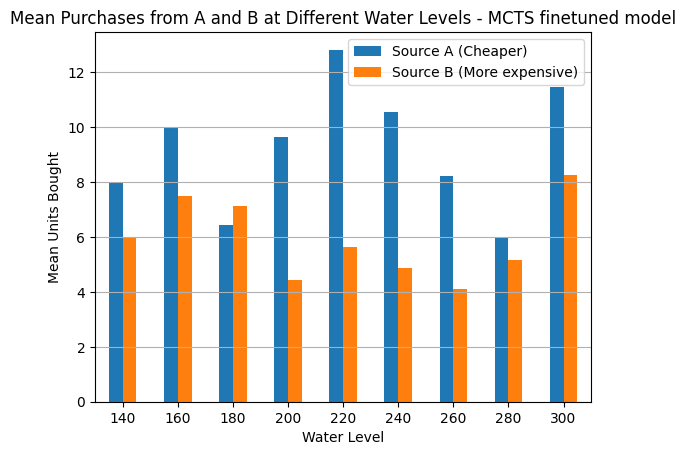

<Figure size 800x600 with 0 Axes>

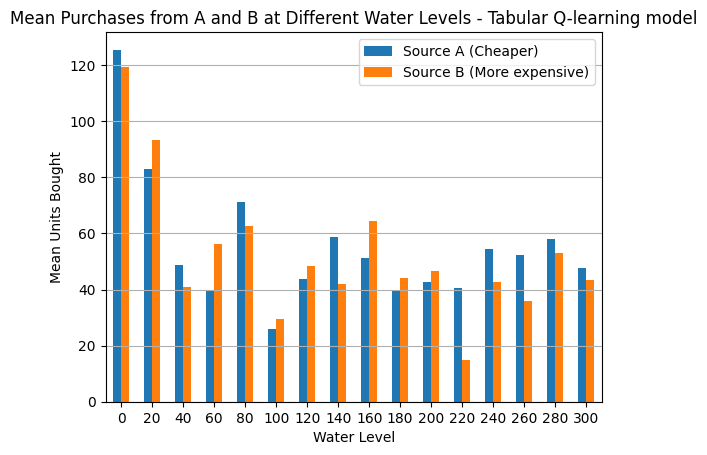

In [32]:
import matplotlib.pyplot as plt

# Plot 1: Bar Chart for "buy_from_a" and "buy_from_b" grouped by Water Level
# Define bins of size 10
def plot_purchase_on_water_level(df: pd.DataFrame, model_name: str):
    df["water_level_bin"] = ((df["water_level"] // 20) * 20).astype(int)  # Groups into 10s

    # Group by the new bins and plot
    plt.figure(figsize=(8, 6))
    df.groupby("water_level_bin")[["buy_from_a", "buy_from_b"]].mean().plot(kind="bar", rot=0)

    # Customize labels and titles
    plt.xlabel("Water Level")
    plt.ylabel("Mean Units Bought")
    plt.title(f"Mean Purchases from A and B at Different Water Levels - {model_name}")
    plt.legend(["Source A (Cheaper)", "Source B (More expensive)"])
    plt.grid(axis="y")
    plt.show()

plot_purchase_on_water_level(df_highlevel, "MCTS finetuned model")
plot_purchase_on_water_level(df_tabular, "Tabular Q-learning model")

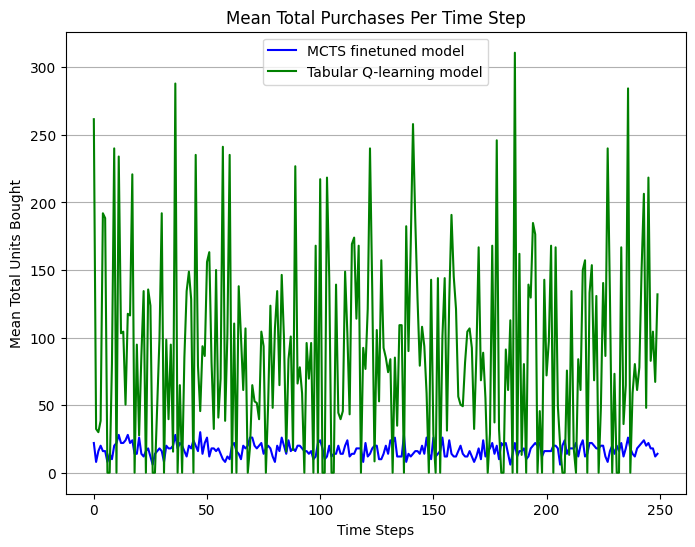

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_purchase_on_time_bucket(df1: pd.DataFrame, df2: pd.DataFrame, label1="Dataset 1", label2="Dataset 2"):  
    """Plots total purchases (sum of buy_from_a and buy_from_b) over time buckets for two DataFrames."""
    
    # Create a new column for total units bought
    df1["total_units_bought"] = df1["buy_from_a"] + df1["buy_from_b"]
    df2["total_units_bought"] = df2["buy_from_a"] + df2["buy_from_b"]
    
    plt.figure(figsize=(8, 6))
    
    # Group by time bucket and compute the mean of total units bought
    grouped_df1 = df1.groupby("timestep")["total_units_bought"].mean()
    grouped_df2 = df2.groupby("timestep")["total_units_bought"].mean()

    # Plot for df1
    plt.plot(grouped_df1.index, grouped_df1, linestyle="-", color="b", label=label1)

    # Plot for df2
    plt.plot(grouped_df2.index, grouped_df2, linestyle="-", color="g", label=label2)

    # Customize labels and titles
    plt.xlabel("Time Steps")
    plt.ylabel("Mean Total Units Bought")
    plt.title("Mean Total Purchases Per Time Step")
    plt.legend()
    plt.grid(axis="y")
    
    # Show the plot
    plt.show()

# Call the function with two DataFrames
plot_purchase_on_time_bucket(df_highlevel, df_tabular, label1="MCTS finetuned model", label2="Tabular Q-learning model")


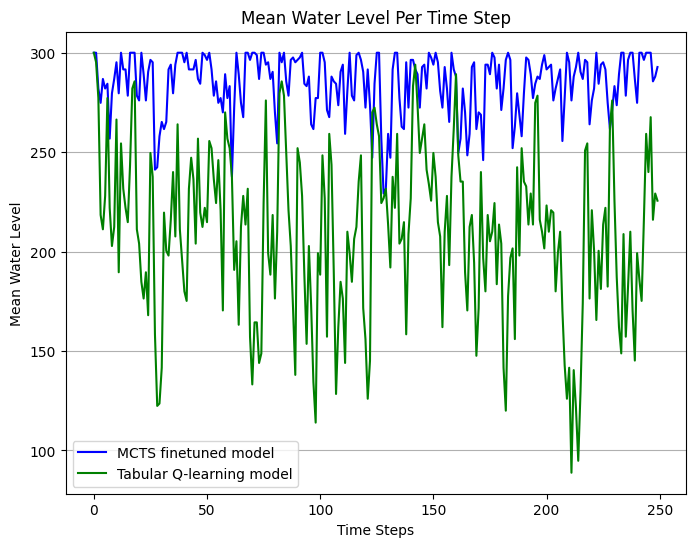

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_water_level_on_timestep(df1: pd.DataFrame, df2: pd.DataFrame, label1="Dataset 1", label2="Dataset 2"):  
    """Plots total purchases (sum of buy_from_a and buy_from_b) over time buckets for two DataFrames."""
    
    plt.figure(figsize=(8, 6))
    
    # Group by time bucket and compute the mean of total units bought
    grouped_df1 = df1.groupby("timestep")["water_level"].mean()
    grouped_df2 = df2.groupby("timestep")["water_level"].mean()

    # Plot for df1
    plt.plot(grouped_df1.index, grouped_df1, linestyle="-", color="b", label=label1)

    # Plot for df2
    plt.plot(grouped_df2.index, grouped_df2, linestyle="-", color="g", label=label2)

    # Customize labels and titles
    plt.xlabel("Time Steps")
    plt.ylabel("Mean Water Level")
    plt.title("Mean Water Level Per Time Step")
    plt.legend()
    plt.grid(axis="y")
    
    # Show the plot
    plt.show()

# Call the function with two DataFrames
plot_water_level_on_timestep(df_highlevel, df_tabular, label1="MCTS finetuned model", label2="Tabular Q-learning model")


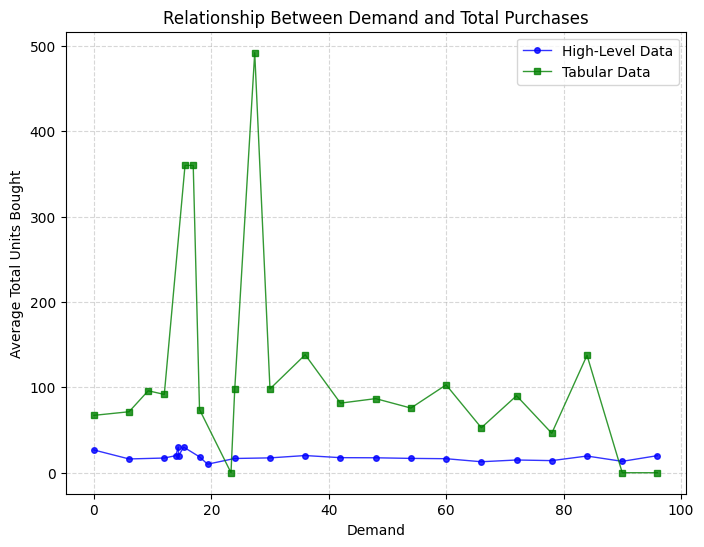

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_total_purchase_vs_demand(df1: pd.DataFrame, df2: pd.DataFrame, label1="Dataset 1", label2="Dataset 2"):  
    """Plots total purchases (buy_from_a + buy_from_b) against demand for two DataFrames on the same plot."""
    
    # Create a new column for total units bought
    df1["total_units_bought"] = df1["buy_from_a"] + df1["buy_from_b"]
    df2["total_units_bought"] = df2["buy_from_a"] + df2["buy_from_b"]
    
    plt.figure(figsize=(8, 6))
    
    # Group by demand and compute the mean of total units bought
    grouped_df1 = df1.groupby("demand")["total_units_bought"].mean()
    grouped_df2 = df2.groupby("demand")["total_units_bought"].mean()

    # Plot for df1
    plt.plot(grouped_df1.index, grouped_df1, marker="o", linestyle="-", color="b", 
             label=label1, markersize=4, linewidth=1, alpha=0.8)

    # Plot for df2
    plt.plot(grouped_df2.index, grouped_df2, marker="s", linestyle="-", color="g", 
             label=label2, markersize=4, linewidth=1, alpha=0.8)

    # Customize labels and titles
    plt.xlabel("Demand")
    plt.ylabel("Average Total Units Bought")
    plt.title("Relationship Between Demand and Total Purchases")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    
    # Show the plot
    plt.show()

# Call the function with two DataFrames
plot_total_purchase_vs_demand(df_highlevel, df_tabular, label1="High-Level Data", label2="Tabular Data")


<Figure size 800x600 with 0 Axes>

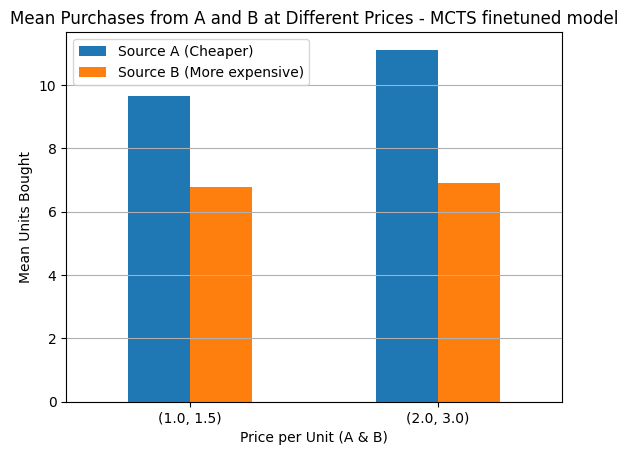

<Figure size 800x600 with 0 Axes>

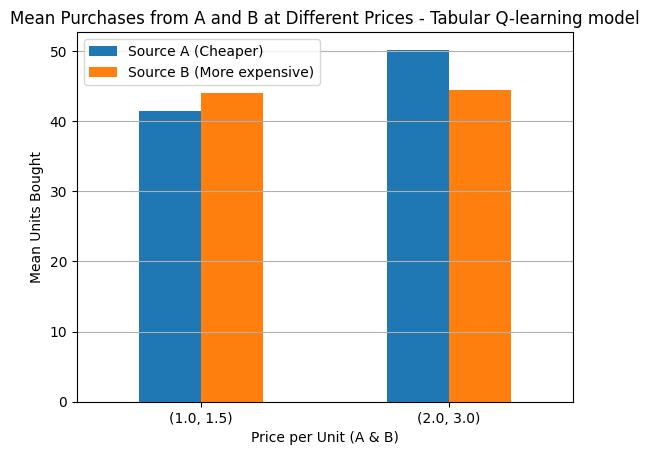

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_purchase_vs_price(df: pd.DataFrame, title: str):  
    """Plots mean purchases from A and B grouped by price_A and price_B as a bar chart."""
    
    plt.figure(figsize=(8, 6))
    
    # Group by price_A and price_B, then calculate mean purchases
    grouped_df = df.groupby(["price_A", "price_B"])[["buy_from_a", "buy_from_b"]].mean()
    
    # Plot as a bar chart
    grouped_df.plot(kind="bar", rot=0)

    # Customize labels and titles
    plt.xlabel("Price per Unit (A & B)")
    plt.ylabel("Mean Units Bought")
    plt.title(f"Mean Purchases from A and B at Different Prices - {title}")
    plt.legend(["Source A (Cheaper)", "Source B (More expensive)"])
    plt.grid(axis="y")
    
    # Show the plot
    plt.show()

# Call the function
plot_purchase_vs_price(df_highlevel, "MCTS finetuned model")
plot_purchase_vs_price(df_tabular, "Tabular Q-learning model")
